In [36]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
from hmpai.training import split_participants, split_participants_custom
from hmpai.pytorch.training import train_and_test
from hmpai.pytorch.utilities import DEVICE, set_global_seed, load_model
from hmpai.pytorch.generators import MultiXArrayProbaDataset
from torch.utils.data import DataLoader
from hmpai.pytorch.normalization import *
from torchvision.transforms import Compose
from hmpai.pytorch.transforms import *
from hmpai.pytorch.mamba import *
from hmpai.visualization import set_seaborn_style
import os
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.utils import resample
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from scipy.spatial.distance import cdist
from scipy.stats import mannwhitneyu, ttest_ind
from sklearn.metrics import pairwise_distances
import ast
DATA_PATH = Path(os.getenv("DATA_PATH"))

legible_labels = ["E1", "C1", "R1", "E2", "C2", "R2"]
labels_all = ["t1_1", "t1_2", "t1_3", "t2_1", "t2_2", "t2_3"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
set_global_seed(42)
data_paths = [DATA_PATH / "prp/stage_data_250hz_t2.nc"]
splits = split_participants_custom(data_paths, 0.15)
cmb_embs_ds = xr.load_dataset("files/cmb_embeddings.nc")

cmb_embs_short = cmb_embs_ds.where(cmb_embs_ds.condition == "short", drop=True)
cmb_embs_long = cmb_embs_ds.sel(participant=splits[1])
cmb_embs_long = cmb_embs_long.where(cmb_embs_long.condition == "long", drop=True)

# Extract embeddings and labels
embs_short = cmb_embs_short.embeddings.values.reshape(-1, cmb_embs_ds.sizes["emb_dim"])
labels_short = np.tile(cmb_embs_short.labels.values, cmb_embs_short.embeddings.shape[:2]).reshape(-1)

# Mask out NaNs
valid_mask_short = ~np.isnan(embs_short).any(axis=1)
embs_short = embs_short[valid_mask_short]
labels_short = labels_short[valid_mask_short]

# Repeat for long
embs_long = cmb_embs_long.embeddings.values.reshape(-1, cmb_embs_ds.sizes["emb_dim"])
labels_long = np.tile(cmb_embs_long.labels.values, cmb_embs_long.embeddings.shape[:2]).reshape(-1)

valid_mask_long = ~np.isnan(embs_long).any(axis=1)
embs_long = embs_long[valid_mask_long]
labels_long = labels_long[valid_mask_long]

In [38]:
def project_embeddings(task, labels_short, labels_long, embs_short, embs_long, proj_path=None):
    if proj_path is not None:
        if proj_path.exists():
            return pd.read_csv(proj_path)
    labels_short_series = pd.Series(labels_short)
    labels_long_series = pd.Series(labels_long)
    embs_short_subset = embs_short[labels_short_series.str.contains(task)]
    embs_long_subset = embs_long[labels_long_series.str.contains(task)]
    conditions = ["short"] * len(embs_short_subset) + ["long"] * len(embs_long_subset)
    embs = np.concatenate((embs_short_subset, embs_long_subset))
    labels = np.concatenate((labels_short_series[labels_short_series.str.contains(task)], labels_long_series[labels_long_series.str.contains(task)]))
    
    tsne = TSNE(n_components=2, random_state=42)
    proj = tsne.fit_transform(embs)
    df = pd.DataFrame({
        'x': proj[:, 0],
        'y': proj[:, 1],
        'label': labels,
        'condition': conditions
    })
    if proj_path is not None:
        df.to_csv(proj_path, index=False)
    return df

def visualize_embeddings(df, task, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6), dpi=300)
    label_palette = sns.color_palette()  # distinct colors per label
    label_colors = {label: color for label, color in zip(sorted(df['label'].unique()), label_palette)}
    condition_lightness_modifier = {'short': 1.4, 'long': 0.6}
    
    def adjust_lightness(color, modifier):
        r, g, b = color
        return (min(1, r * modifier), min(1, g * modifier), min(1, b * modifier))
    
    # Plot each (label, condition) group with matching color/shape
    for (label, condition), group in df.groupby(['label', 'condition']):
        base_color = label_colors[label]
        adjusted_color = adjust_lightness(base_color, condition_lightness_modifier[condition])
        ax.scatter(
            group['x'], group['y'],
            c=[adjusted_color],
            marker='o',
            s=1,
            alpha=0.3,
            label=f"{legible_labels[labels_all.index(label)]} ({condition})",
        )

    # Plot centroids
    centroids = df.groupby(['label', 'condition'])[['x', 'y']].mean().reset_index()
    for _, row in centroids.iterrows():
        base_color = label_colors[row['label']]
        adjusted_color = adjust_lightness(base_color, condition_lightness_modifier[row['condition']])
        ax.scatter(
            row['x'], row['y'],
            c=[adjusted_color],
            marker='o',
            s=50,
            edgecolor='black',
            linewidth=1.2,
            zorder=5,
        )
        ax.text(row['x'] + 4.5, row['y'] - 7, f"{legible_labels[labels_all.index(row['label'])]}", fontsize=9)
    for (label, condition), group in df.groupby(['label', 'condition']):
        base_color = label_colors[label]
        adjusted_color = adjust_lightness(base_color, condition_lightness_modifier[condition])
        sns.kdeplot(
            x=group['x'], y=group['y'],
            ax=ax,
            levels=2,
            color=adjusted_color,
            linestyles='solid',
            linewidths=1,
            alpha=1.0,
            # bw_adjust=0.5,
        )
    ax.axis("off")
    ax.set_title("Task 1" if task == "t1" else "Task 2")
    # Final plot settings
    # Create clean legend handles manually
    if task == "t2":
        legend_elements = []
        for (label, condition), group in df.groupby(['label', 'condition']):
            base_color = label_colors[label]
            adjusted_color = adjust_lightness(base_color, condition_lightness_modifier[condition])
            patch = mpatches.Patch(
                color=adjusted_color,
                label=f"{legible_labels[labels_all.index(label)][:1]} ({condition})",
                alpha=1.0
            )
            legend_elements.append(patch)

        # Deduplicate entries
        seen = {}
        legend_clean = []
        for item in legend_elements:
            if item.get_label() not in seen:
                seen[item.get_label()] = True
                legend_clean.append(item)

        ax.legend(
            handles=legend_clean,
            bbox_to_anchor=(-0.5, 1.10),
            loc='upper left',
            title="Label (Condition)"
        )
    # plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left', title="Label (Condition)")

    return ax

In [39]:
def calculate_distances(source, target, labels_short, labels_long, embs_short, embs_long, dist_path=None):
    if dist_path is not None:
        if dist_path.exists():
            data = np.load(dist_path)
            data = data[data.files[0]]
            return data

    if source == 'short':
        source_embs = embs_short
        source_labels = labels_short
    else:
        source_embs = embs_long
        source_labels = labels_long
    if target == 'short':
        target_embs = embs_short
        target_labels = labels_short
    else:
        target_embs = embs_long
        target_labels = labels_long
    max_source = pd.Series(source_labels).value_counts().max()
    max_target = pd.Series(target_labels).value_counts().max()
    arr = np.full((len(labels_all), len(labels_all), max_source * max_target), np.nan)
    print(arr.shape)

    for i_x, label_x in tqdm(enumerate(labels_all), total=len(labels_all)):
        for i_y, label_y in enumerate(labels_all):
            # Calculate the distance between the two embeddings
            label_subset_source = source_embs[source_labels == label_x]
            label_subset_target = target_embs[target_labels == label_y]

            # Bootstrap pairwise distances between embeddings
            if len(label_subset_target) > 0 and len(label_subset_target) > 0:
                label_dists = pairwise_distances(label_subset_source, label_subset_target, metric='cosine').flatten()
                arr[i_x, i_y, :len(label_dists)] = label_dists

    if dist_path is not None:
        np.savez(dist_path, arr=arr)

    return arr

def plot_distance_matrix(distance_dists, legible_labels, source, target, ax=None, cbar=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 4), dpi=300)
    matrix = np.nanmean(distance_dists, axis=2)
    matrix_df = pd.DataFrame(matrix, index=legible_labels, columns=legible_labels)
    # Plot matrix
    sns.heatmap(matrix_df, annot=True, fmt=".2f", square=True, cmap=sns.light_palette("firebrick", reverse=True, as_cmap=True), cbar_kws={"label": "Cosine Distance", "location": "left"}, ax=ax, cbar=cbar)

    ax.set_title(f"{source.capitalize()} vs {target.capitalize()}")
    ax.set_xticklabels(legible_labels, rotation=0)
    ax.set_yticklabels(legible_labels, rotation=0)
    if cbar:
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")

def plot_distance_differences(dists_1, dists_2, ax):
    # dists1 = long_short
    # dists2 = long_long
    z_diag_all = []
    z_block_all = []
    for i, label in enumerate(labels_all):
        # if i == 2: # Skip R1
        #     continue
        # Diagonal distances from dists_1
        dists_a = np.abs(dists_1[i, i, :])
        dists_a = np.random.choice(dists_a[~np.isnan(dists_a)], size=10000, replace=True)

        # Diagonal from dists_2 (same label)
        dists_b_diag = np.abs(dists_2[i, i, :])
        dists_b_diag = np.random.choice(dists_b_diag[~np.isnan(dists_b_diag)], size=10000, replace=True)

        # Block from dists_2 (same condition)
        i1 = 0 if i < 3 else 3
        i2 = 3 if i < 3 else 6
        dists_b_block = np.abs(dists_2[i1:i2, i1:i2, :])
        dists_b_block[i if i < 3 else i - 3, i if i < 3 else i - 3, :] = np.nan
        dists_b_block = np.random.choice(dists_b_block[~np.isnan(dists_b_block)], size=10000, replace=True)

        # Z-score dists_a with respect to dists_b_diag
        z_diag = (dists_a - np.mean(dists_b_diag)) / np.std(dists_b_diag)
        z_diag_all.extend(z_diag)
        print("Z-score stats (diag):", np.mean(z_diag), np.std(z_diag))
        # Z-score dists_a with respect to dists_b_block
        z_block = (dists_a - np.mean(dists_b_block)) / np.std(dists_b_block)
        z_block_all.extend(z_block)
        print("Z-score stats (block):", np.mean(z_block), np.std(z_block))
        print(f"Mean A: {np.mean(dists_a):.3f}, STD A: {np.std(dists_a):.3f}")
        print(f"Mean B_diag: {np.mean(dists_b_diag):.3f}, STD B_diag: {np.std(dists_b_diag):.3f}")
        # Plot both
        sns.kdeplot(z_diag, ax=ax, label=f"{legible_labels[i]} (vs diag)", fill=True, alpha=0.5, linewidth=1.5)
        # sns.histplot(z_diag, ax=ax, label=f"{legible_labels[i]} (vs diag)", fill=True, alpha=0.5)
        sns.kdeplot(z_block, ax=ax, label=f"{legible_labels[i]} (vs block)", fill=False, linewidth=1.5, linestyle='--')
        # sns.histplot(z_block, ax=ax, label=f"{legible_labels[i]} (vs block)", fill=False, linewidth=1.5, linestyle='--')
    # print("Z-score stats (diag):", np.mean(z_diag_all), np.std(z_diag_all))
    # print("Z-score stats (block):", np.mean(z_block_all), np.std(z_block_all))
    # sns.kdeplot(z_diag_all, ax=ax, label="Diag", fill=True, linewidth=1.5)
    # sns.kdeplot(z_block_all, ax=ax, label="Block", fill=False, linewidth=1.5, linestyle='--')
    # ax.vlines(np.mean(z_diag_all), color='blue', linestyle='--', label='Mean Diag', ymin=0, ymax=2)
    # ax.vlines(np.mean(z_block_all), color='orange', linestyle='--', label='Mean Block', ymin=0, ymax=2)

    # plt.ylabel("Mean Z-score")
    # plt.title("Each point: Label-wise comparison of Z-score")
    # plt.show()
    # ax.legend()
    ax.vlines(0, linestyle='--', color='gray', ymin=0, ymax=2)
    ax.set_xlim(-3, 3)
    ax.set_title("Z-scored Cosine Distances: Diagonal vs Block")


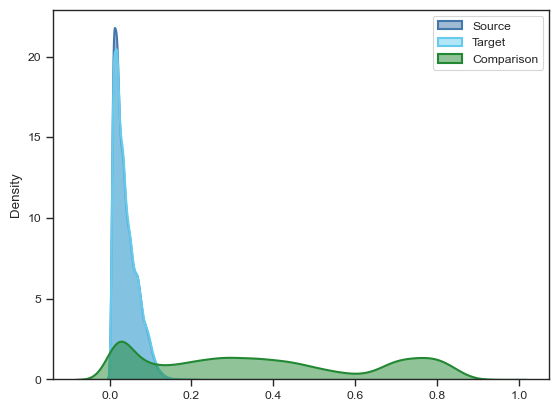

In [43]:
cls_id = 2
source = distances_long_short[cls_id, cls_id, :]
target = distances_long_long[cls_id, cls_id, :]
comparison = distances_long_long[:3, :3, :].copy()
comparison[cls_id, cls_id, :] = np.nan
comparison = comparison.flatten()
set_seaborn_style()
sns.kdeplot(np.random.choice(source, size=100000, replace=True), label="Source", fill=True, alpha=0.5, linewidth=1.5)
sns.kdeplot(np.random.choice(target, size=100000, replace=True), label="Target", fill=True, alpha=0.5, linewidth=1.5)
sns.kdeplot(np.random.choice(comparison, size=100000, replace=True), label="Comparison", fill=True, alpha=0.5, linewidth=1.5)
plt.legend()
plt.show()

0

In [67]:
from scipy.stats import norm

def asymptotic_ci(source, target):
    source = source[~np.isnan(source)]
    target = target[~np.isnan(target)]
    mean_source = np.mean(source)
    mean_target = np.mean(target)
    var_source = np.var(source)
    var_target = np.var(target)
    n_source = len(source)
    n_target = len(target)
    
    delta = mean_source - mean_target
    se = np.sqrt(var_source / n_source + var_target / n_target)
    z = delta / se
    ci95 = (delta - 1.96*se, delta + 1.96*se)
    p_two = 2*(1 - norm.cdf(abs(z)))
    return mean_source, mean_target, ci95[0], ci95[1]

In [78]:
results = []
for i, label in enumerate(legible_labels):
    source = distances_long_short[i, i, :]
    target = distances_long_long[i, i, :]
    i1 = 0 if i < 3 else 3
    i2 = 3 if i < 3 else 6
    comparison = distances_long_long[i1:i2, i1:i2, :].copy()
    comparison[i if i < 3 else i - 3, i if i < 3 else i - 3, :] = np.nan
    comparison = comparison.flatten()
    
    print(f"Label: {legible_labels[i]}")
    mean_source, mean_target, target_lo, target_hi = asymptotic_ci(source, target)
    mean_source, mean_comparison, comparison_lo, comparison_hi = asymptotic_ci(source, comparison)

    results.append({
        "label": label,
        "type": "target",
        "mean": mean_target,
        "ci_lo": target_lo,
        "ci_hi": target_hi,
    })
    results.append({
        "label": label,
        "type": "comparison",
        "mean": mean_comparison,
        "ci_lo": comparison_lo,
        "ci_hi": comparison_hi,
    })
results_df = pd.DataFrame(results)

Label: E1
Label: C1
Label: R1
Label: E2
Label: C2
Label: R2


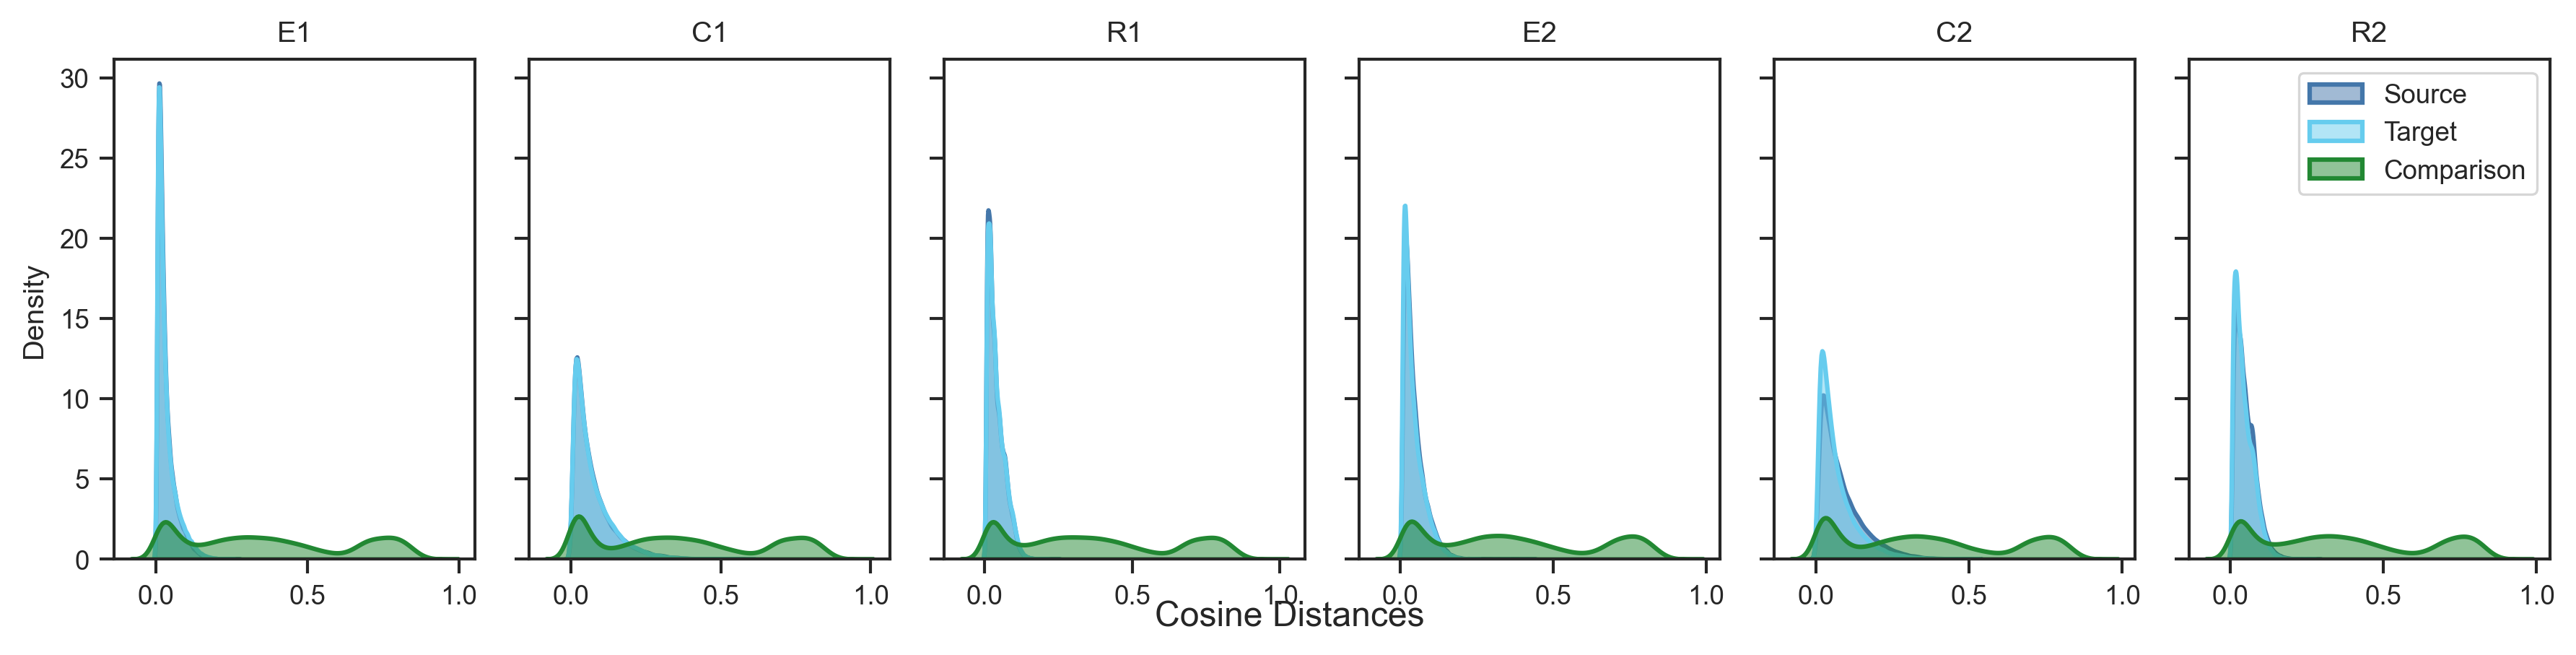

In [93]:
fig, ax = plt.subplots(1, len(legible_labels), figsize=(12, 3), dpi=300, sharey=True)
for i, label in enumerate(legible_labels):
    source = distances_long_short[i, i, :]
    target = distances_long_long[i, i, :]
    i1 = 0 if i < 3 else 3
    i2 = 3 if i < 3 else 6
    comparison = distances_long_long[i1:i2, i1:i2, :].copy()
    comparison[i if i < 3 else i - 3, i if i < 3 else i - 3, :] = np.nan
    comparison = comparison.flatten()

    source = np.random.choice(source, size=100000, replace=True)
    target = np.random.choice(target, size=100000, replace=True)
    comparison = np.random.choice(comparison, size=100000, replace=True)

    sns.kdeplot(source, ax=ax[i], label="Source", fill=True, alpha=0.5, linewidth=1.5)
    sns.kdeplot(target, ax=ax[i], label="Target", fill=True, alpha=0.5, linewidth=1.5)
    sns.kdeplot(comparison, ax=ax[i], label="Comparison", fill=True, alpha=0.5, linewidth=1.5)
    ax[i].set_title(f"{legible_labels[i]}")
plt.tight_layout()
fig.supxlabel("Cosine Distances")
plt.legend()
plt.show()

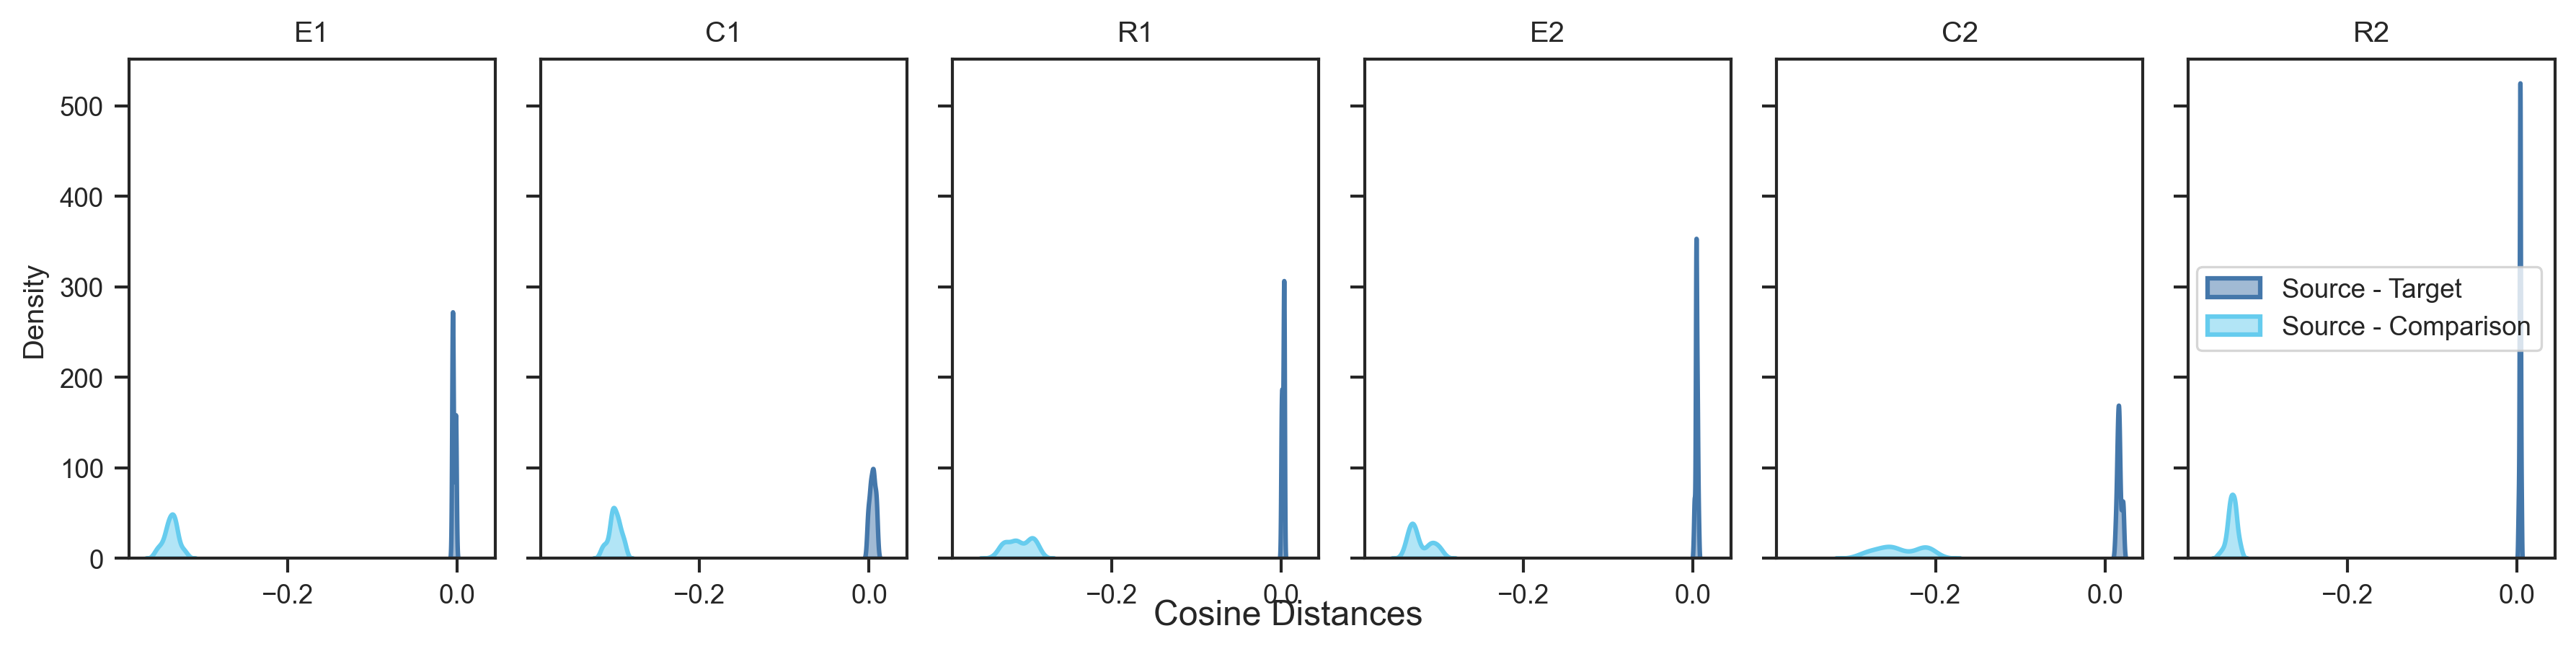

In [101]:
fig, ax = plt.subplots(1, len(legible_labels), figsize=(12, 3), dpi=300, sharey=True, sharex=True)
for i, label in enumerate(legible_labels):
    source = distances_long_short[i, i, :]
    target = distances_long_long[i, i, :]
    i1 = 0 if i < 3 else 3
    i2 = 3 if i < 3 else 6
    comparison = distances_long_long[i1:i2, i1:i2, :].copy()
    comparison[i if i < 3 else i - 3, i if i < 3 else i - 3, :] = np.nan
    comparison = comparison.flatten()

    source = source[~np.isnan(source)]
    target = target[~np.isnan(target)]
    comparison = comparison[~np.isnan(comparison)]

    N = 100
    diffs_st = np.empty(N)
    diffs_sc = np.empty(N)

    for i_N in range(N):
        source = np.random.choice(source, size=10000, replace=True)
        target = np.random.choice(target, size=10000, replace=True)
        comparison = np.random.choice(comparison, size=10000, replace=True)
        diffs_st[i_N] = np.mean(source) - np.mean(target)
        diffs_sc[i_N] = np.mean(source) - np.mean(comparison)


    sns.kdeplot(diffs_st.flatten(), ax=ax[i], label="Source - Target", fill=True, alpha=0.5, linewidth=1.5)
    sns.kdeplot(diffs_sc.flatten(), ax=ax[i], label="Source - Comparison", fill=True, alpha=0.5, linewidth=1.5)

    ax[i].set_title(f"{legible_labels[i]}")
plt.tight_layout()
fig.supxlabel("Cosine Distances")
plt.legend()
plt.show()

Text(0.5, 0, 'Operation')

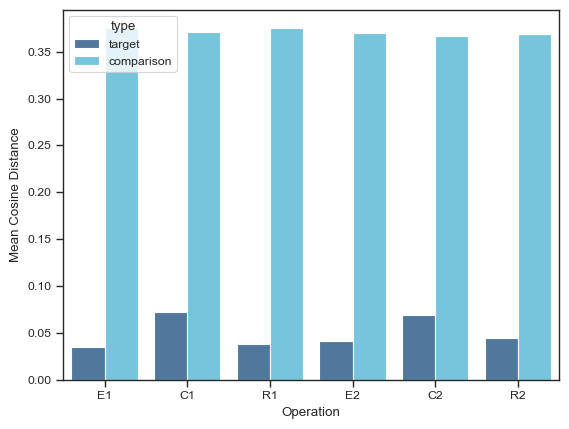

In [81]:
sns.barplot(data=results_df, x="label", y="mean", hue="type", errorbar=None)
plt.ylabel("Mean Cosine Distance")
plt.xlabel("Operation")

In [97]:
distances_long_long = calculate_distances("long", "long", labels_short, labels_long, embs_short, embs_long, Path("files/long_long_distances_cosine2.npz"))
distances_long_short = calculate_distances("short", "long", labels_short, labels_long, embs_short, embs_long, Path("files/long_short_distances_cosine2.npz"))

Z-score stats (diag): -0.023705617205998494 0.9597502772565778
Z-score stats (block): -1.2853785015794856 0.11313700812015277
Mean A: 0.034, STD A: 0.030
Mean B_diag: 0.034, STD B_diag: 0.032
Z-score stats (diag): 0.01606196918887709 1.0167357064548581
Z-score stats (block): -1.0975717287347946 0.24415467446908437
Mean A: 0.073, STD A: 0.067
Mean B_diag: 0.072, STD B_diag: 0.065
Z-score stats (diag): -0.02862440296256857 0.9901385234025193
Z-score stats (block): -1.2381720408403494 0.10281968245112932
Mean A: 0.038, STD A: 0.028
Mean B_diag: 0.038, STD B_diag: 0.028
Z-score stats (diag): 0.06953368497355115 1.0239409044514658
Z-score stats (block): -1.252544750077598 0.1292686287100804
Mean A: 0.044, STD A: 0.034
Mean B_diag: 0.041, STD B_diag: 0.033
Z-score stats (diag): 0.21563873619089205 1.132420911821909
Z-score stats (block): -1.0562105038755178 0.2567502365769696
Mean A: 0.083, STD A: 0.069
Mean B_diag: 0.070, STD B_diag: 0.061
Z-score stats (diag): 0.12112444853135287 1.0226029

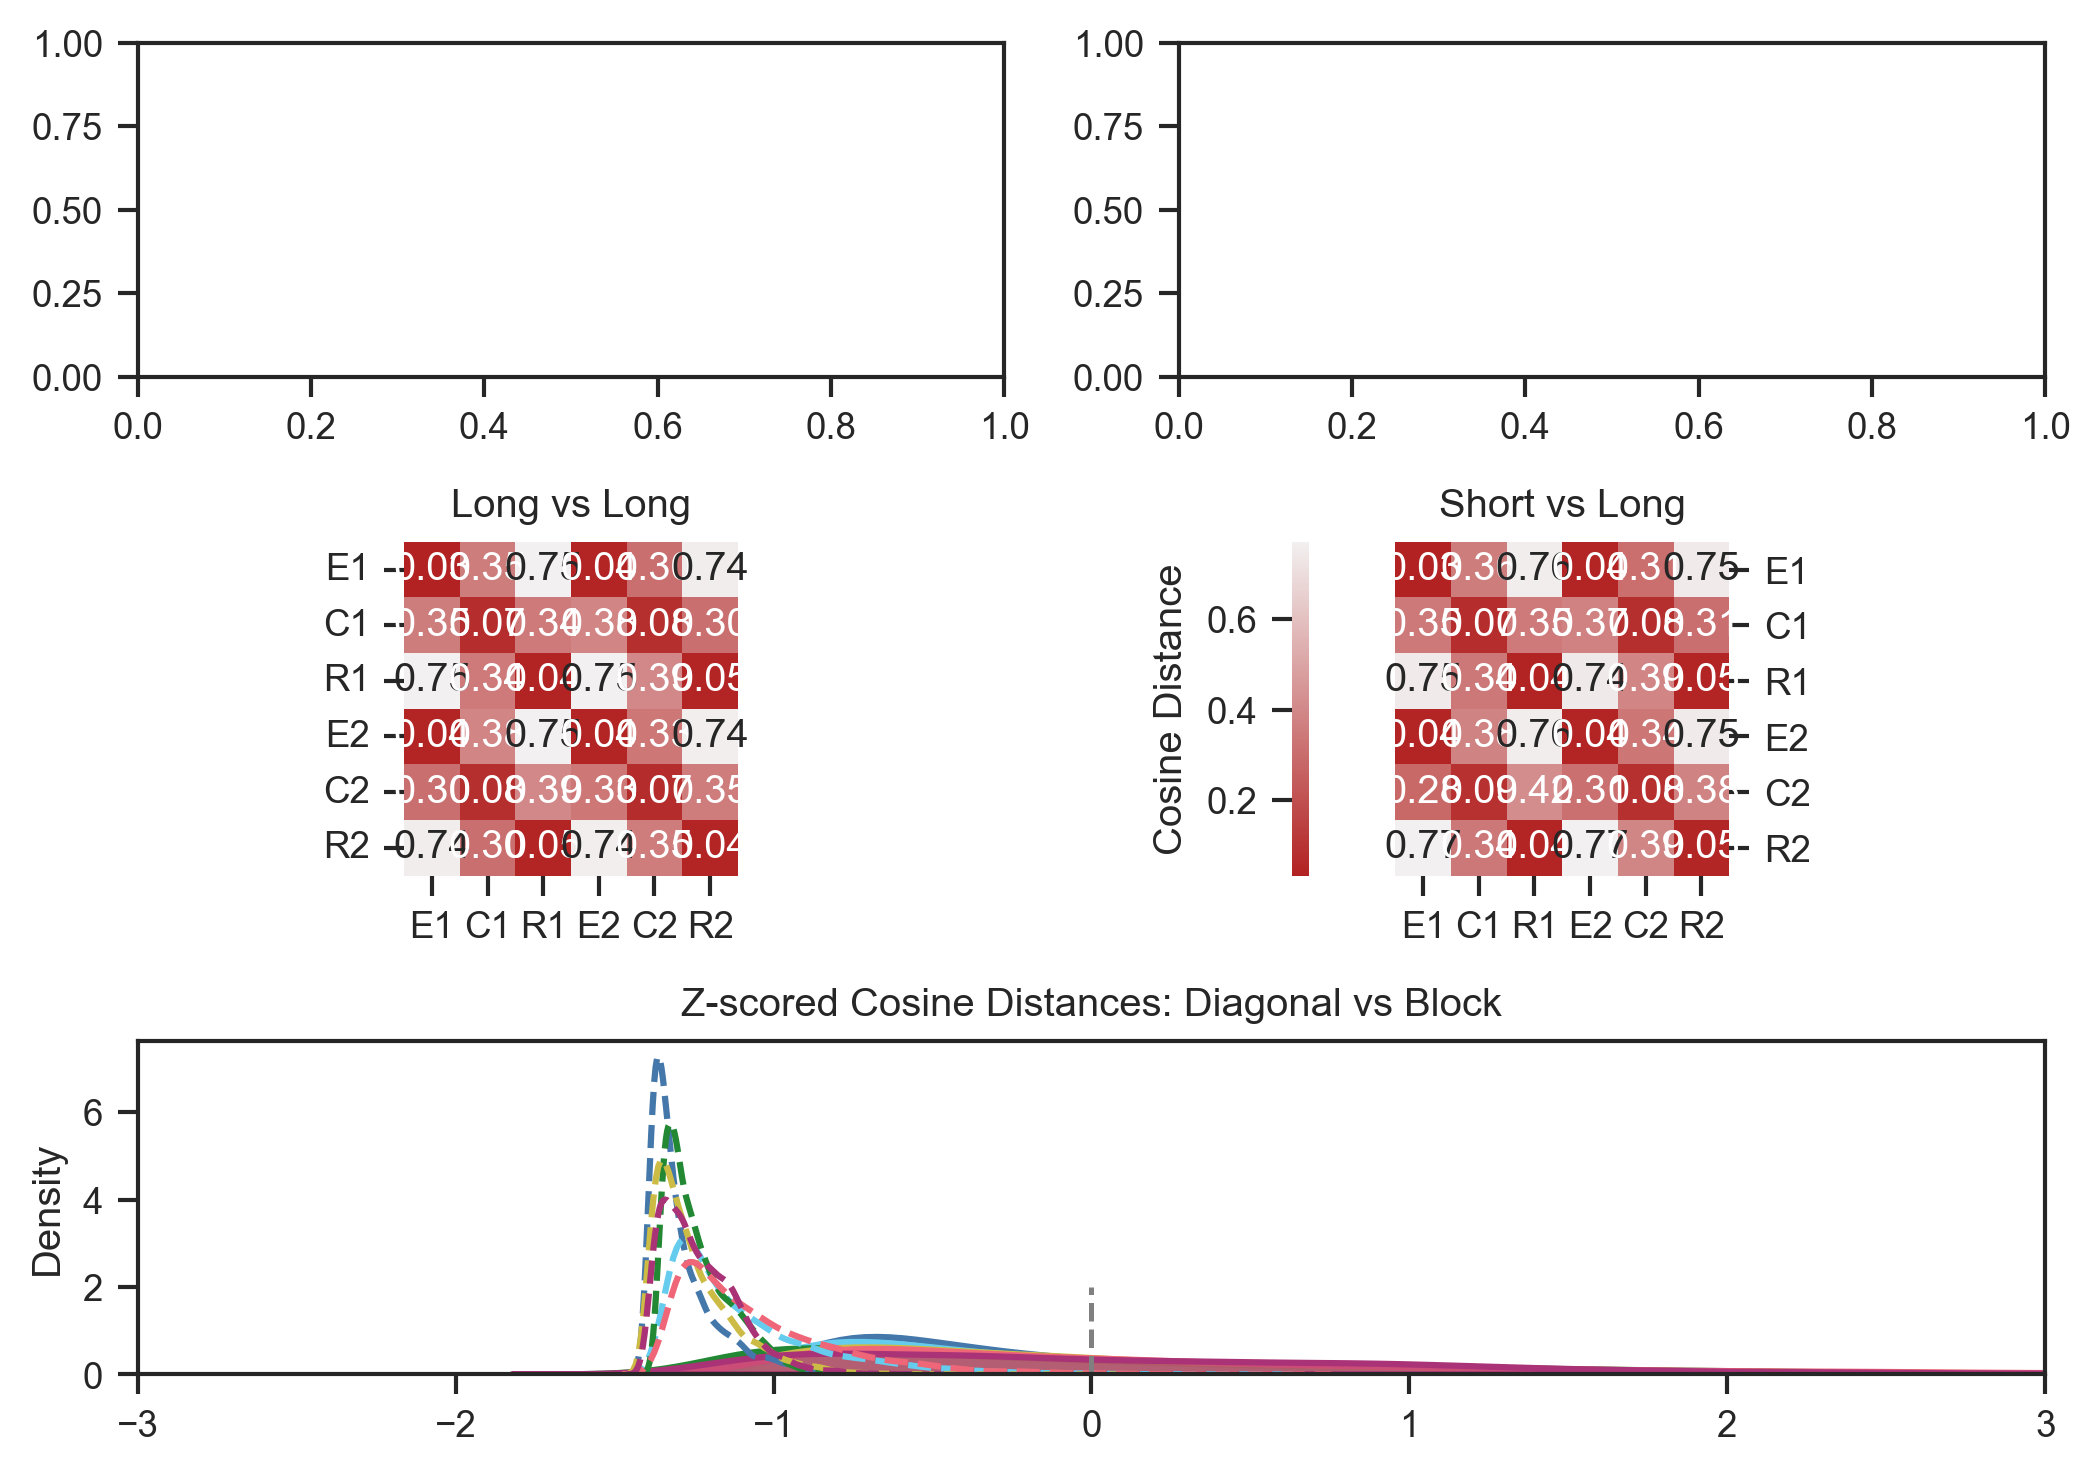

In [16]:
from matplotlib import gridspec
import matplotlib.patches as mpatches

def plot_all():
    set_seaborn_style()
    # fig, axs = plt.subplots(3, 2, dpi=300, figsize=(7.09, 7.09), sharey='row')
    fig = plt.figure(figsize=(7.09, 5), dpi=300)
    gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])

    # Create axes
    axs = np.empty((3, 2), dtype=object)
    axs[0, 0] = fig.add_subplot(gs[0, 0])
    axs[0, 1] = fig.add_subplot(gs[0, 1])
    axs[1, 0] = fig.add_subplot(gs[1, 0])
    axs[1, 1] = fig.add_subplot(gs[1, 1])
    ax_bottom = fig.add_subplot(gs[2, :])  # spans the whole bottom row

    # Plot t-sne embeddings (t1, t2)
    t1_embs = project_embeddings("t1", labels_short, labels_long, embs_short, embs_long, Path("files/t1_projections.csv"))
    t2_embs = project_embeddings("t2", labels_short, labels_long, embs_short, embs_long, Path("files/t2_projections.csv"))
    # visualize_embeddings(t1_embs, "t1", axs[0, 0])
    # visualize_embeddings(t2_embs, "t2", axs[0, 1])

    # Plot matrices ((long, long), (short, long))
    # distances_long_long = calculate_distances("long", "long", labels_short, labels_long, embs_short, embs_long, Path("files/long_long_distances.npz"))
    # distances_long_short = calculate_distances("short", "long", labels_short, labels_long, embs_short, embs_long, Path("files/long_short_distances.npz"))
    plot_distance_matrix(distances_long_long, legible_labels, "long", "long", axs[1, 0], cbar=False)
    plot_distance_matrix(distances_long_short, legible_labels, "short", "long", axs[1, 1], cbar=True)
    axs[1, 0].tick_params(labelbottom=True)
    axs[1, 1].tick_params(labelbottom=True)
    
    # # Plot difference kde's (full width)
    plot_distance_differences(distances_long_short, distances_long_long, ax_bottom)

    plt.tight_layout()
    fig.show()

plot_all()

In [10]:
source, target = 'long', 'long'
distances_long_long, matrix_long_long = calculate_distances(source, target)

  0%|          | 0/6 [00:00<?, ?it/s]

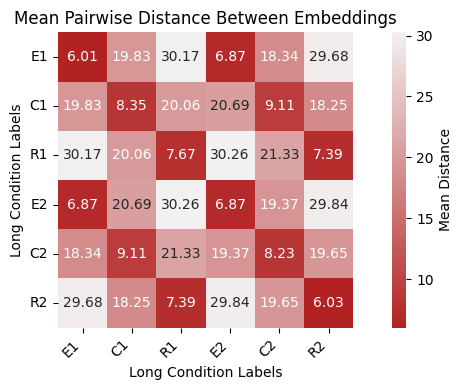

In [40]:
fig = plot_distance_matrix(matrix_long_long, legible_labels, source, target)

In [33]:
source, target = 'short', 'long'
distances_long_short, matrix_long_short = calculate_distances(source, target)

TypeError: calculate_distances() missing 4 required positional arguments: 'labels_short', 'labels_long', 'embs_short', and 'embs_long'

In [ ]:
plot_distance_matrix(matrix_long_short, legible_labels, source, target)

In [32]:
def bootstrap_diff(dist_a, dist_b, n_iter=1000, sample_size=100):
    diffs = []
    for _ in range(n_iter):
        sample_a = resample(dist_a, n_samples=sample_size, replace=True)
        sample_b = resample(dist_b, n_samples=sample_size, replace=True)
        diff = np.mean(sample_a) - np.mean(sample_b)
        diffs.append(diff)
    return np.array(diffs)

labels_t1 = ['t1_1', 't1_2', 't1_3']
labels_t2 = ['t2_1', 't2_2', 't2_3']

for label in labels_t1:
    same = distances_long_short[(label, label)]
    other_cond = distances_long_long[(label, label)]
    diffs = bootstrap_diff(same, other_cond, n_iter=1000, sample_size=100)
    ci = np.percentile(diffs, [2.5, 97.5])
    mean_diff = np.mean(diffs)
    print(f"{label}: Δmean = {mean_diff:.4f}, 95% CI = {ci}")
for label in labels_t2:
    same = distances_long_short[(label, label)]
    other_cond = distances_long_long[(label, label)]
    diffs = bootstrap_diff(same, other_cond, n_iter=1000, sample_size=100)
    ci = np.percentile(diffs, [2.5, 97.5])
    mean_diff = np.mean(diffs)
    print(f"{label}: Δmean = {mean_diff:.4f}, 95% CI = {ci}")

NameError: name 'distances_long_short' is not defined

In [7]:
labels_t1 = ['t1_1', 't1_2', 't1_3']
labels_t2 = ['t2_1', 't2_2', 't2_3']
for label in labels_t1:
    same = distances_long_short[(label, label)]
    other_cond = distances_long_long[(label, label)]
    others = [
        d for other_label in labels_t1 if other_label != label
        for d in distances_long_short[(label, other_label)]
    ]
    stat, p = ttest_ind(same, other_cond, alternative='two-sided')
    print(f"{label}: {stat:.2f}, p-value: {p:.4f}, {np.mean(same):.2f} vs {np.mean(other_cond):.2f}")
for label in labels_t2:
    same = distances_long_short[(label, label)]
    other_cond = distances_long_long[(label, label)]
    stat, p = ttest_ind(same, other_cond, alternative='two-sided')
    print(f"{label}: {stat:.2f}, p-value: {p:.4f}, {np.mean(same):.2f} vs {np.mean(other_cond):.2f}")

t1_1: -72.81, p-value: 0.0000, 5.92 vs 6.01
t1_2: -8.95, p-value: 0.0000, 8.34 vs 8.35
t1_3: -20.68, p-value: 0.0000, 7.62 vs 7.67
t2_1: 95.28, p-value: 0.0000, 6.99 vs 6.87
t2_2: 414.40, p-value: 0.0000, 8.97 vs 8.23
t2_3: 332.17, p-value: 0.0000, 6.39 vs 6.03


In [ ]:
### PER TASK
set_seaborn_style()
labels_short_series = pd.Series(labels_short)
labels_long_series = pd.Series(labels_long)
dfs = []




for task in ["t1", "t2"]:
    if task == "t1":
        embs_short_subset = embs_short[labels_short_series.str.contains("t1")]
        embs_long_subset = embs_long[labels_long_series.str.contains("t1")]
        conditions = ["short"] * len(embs_short_subset) + ["long"] * len(embs_long_subset)
        embs = np.concatenate((embs_short_subset, embs_long_subset))
        labels = np.concatenate((labels_short_series[labels_short_series.str.contains("t1")], labels_long_series[labels_long_series.str.contains("t1")]))
    else:
        embs_short_subset = embs_short[labels_short_series.str.contains("t2")]
        embs_long_subset = embs_long[labels_long_series.str.contains("t2")]
        conditions = ["short"] * len(embs_short_subset) + ["long"] * len(embs_long_subset)
        embs = np.concatenate((embs_short_subset, embs_long_subset))
        labels = np.concatenate((labels_short_series[labels_short_series.str.contains("t2")], labels_long_series[labels_long_series.str.contains("t2")]))
    tsne = TSNE(n_components=2, random_state=42)
    proj = tsne.fit_transform(embs)
    # reducer = umap.UMAP(random_state=42)
    # proj = reducer.fit_transform(embs, ensure_all_finite=False)
    # pca = PCA(n_components=2)
    # proj = pca.fit_transform(embs)
    df = pd.DataFrame({
        'x': proj[:, 0],
        'y': proj[:, 1],
        'label': labels,
        'condition': conditions
    })
    dfs.append(df)

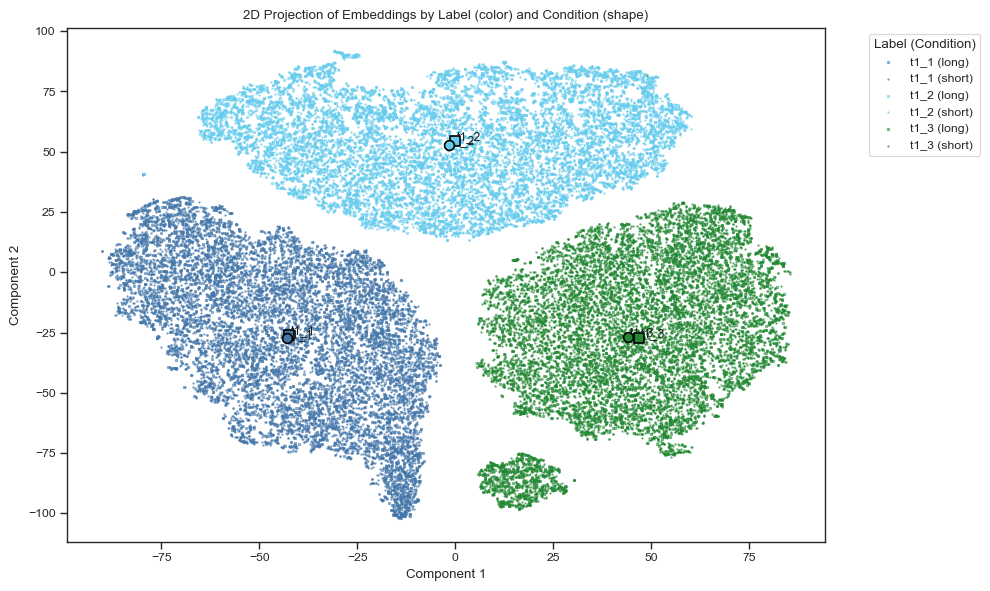

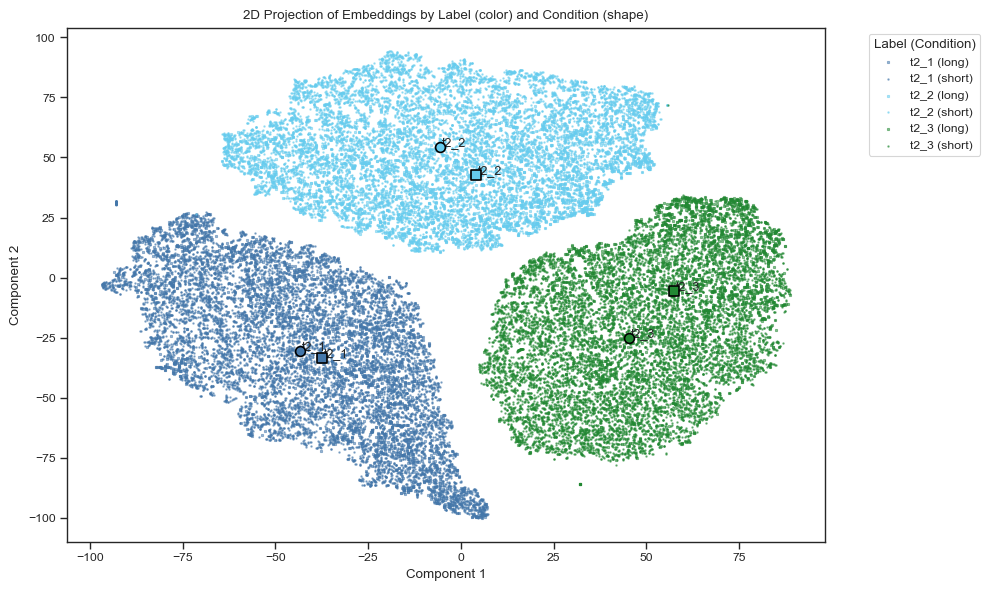

In [10]:
for df in dfs:
    condition_markers = {'short': 'o', 'long': 's'}  # circle for short, square for long
    label_palette = sns.color_palette()  # distinct colors per label
    label_colors = {label: color for label, color in zip(sorted(df['label'].unique()), label_palette)}
    set_seaborn_style()
    plt.figure(figsize=(10, 6))

    # Plot each (label, condition) group with matching color/shape
    for (label, condition), group in df.groupby(['label', 'condition']):
        plt.scatter(
            group['x'], group['y'],
            c=[label_colors[label]],
            marker=condition_markers[condition],
            s=1,
            alpha=0.5,
            label=f"{label} ({condition})"
        )

    # Plot centroids
    centroids = df.groupby(['label', 'condition'])[['x', 'y']].mean().reset_index()
    for _, row in centroids.iterrows():
        plt.scatter(
            row['x'], row['y'],
            c=[label_colors[row['label']]],
            marker=condition_markers[row['condition']],
            s=50,
            edgecolor='black',
            linewidth=1.2,
            zorder=5
        )
        plt.text(row['x'] + 0.5, row['y'], f"{row['label']}", fontsize=9)

    # Final plot settings
    handles, labels_ = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels_, handles))  # avoid duplicates
    plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left', title="Label (Condition)")

    plt.title("2D Projection of Embeddings by Label (color) and Condition (shape)")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.tight_layout()
    plt.show()

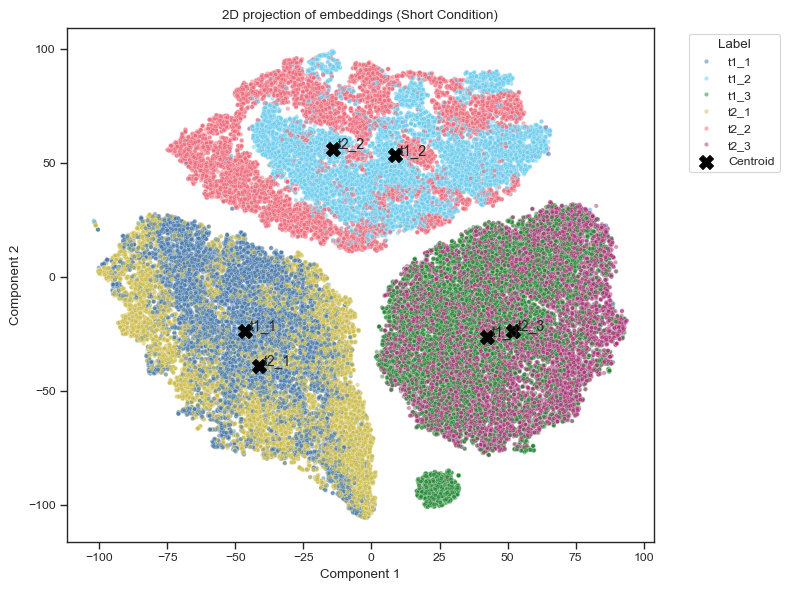

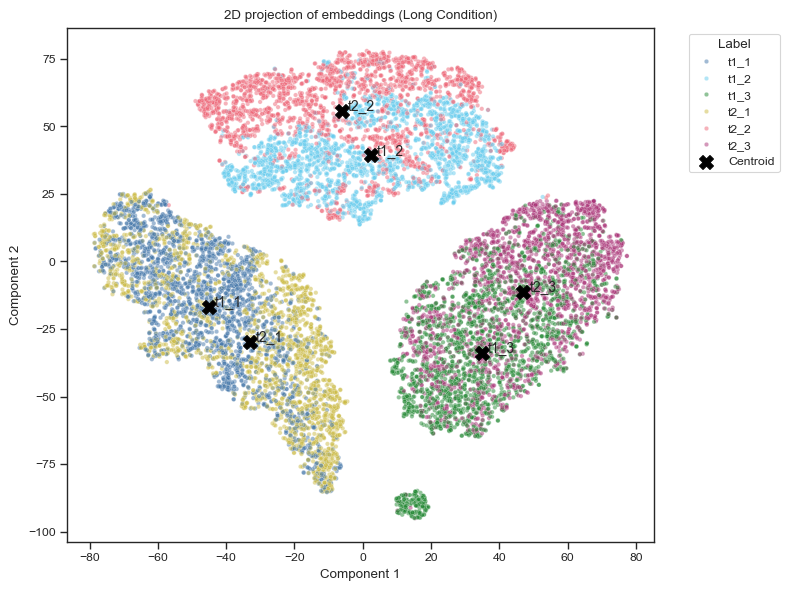

In [7]:
### PER CONDITION
set_seaborn_style()
for cond in ["short", "long"]:
    if cond == "short":
        embs = embs_short
        labels = labels_short
    else:
        embs = embs_long
        labels = labels_long
    tsne = TSNE(n_components=2)
    proj = tsne.fit_transform(embs)
    df = pd.DataFrame({
        'x': proj[:, 0],
        'y': proj[:, 1],
        'label': labels
    })

    # Compute centroids
    centroids = df.groupby('label')[['x', 'y']].mean().reset_index()

    plt.figure(figsize=(8,6))
    sns.scatterplot(x=proj[:,0], y=proj[:,1], hue=labels, alpha=0.5, s=10)
    plt.scatter(
        centroids['x'], centroids['y'],
        c='black', s=100, marker='X', label='Centroid'
    )
    for _, row in centroids.iterrows():
        plt.text(row['x'] + 1.75, row['y'], str(row['label']), fontsize=10)
    plt.title(f"2D projection of embeddings ({cond.capitalize()} Condition)")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(title="Label", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

### Combined (new)

In [9]:
cmb_embs_ds = xr.load_dataset("files/cmb_embeddings.nc")

labels_cmb = []
embeddings_cmb = []
for label in cmb_embs_ds.labels.values:
    label_subset = cmb_embs_ds.sel(labels=label)
    embeddings_subset = label_subset.embeddings.values.reshape(-1, label_subset.emb_dim.size)
    embeddings_subset = embeddings_subset[~np.isnan(embeddings_subset).any(axis=1)]
    print(f"Label: {label}, Shape: {embeddings_subset.shape}")
    labels_cmb.extend([label] * embeddings_subset.shape[0])
    embeddings_cmb.append(embeddings_subset)
labels_cmb = np.array(labels_cmb)
embeddings_cmb = np.concatenate(embeddings_cmb, axis=0)

Label: t1_1, Shape: (23644, 513)
Label: t1_2, Shape: (23644, 513)
Label: t1_3, Shape: (23644, 513)
Label: t2_1, Shape: (23194, 513)
Label: t2_2, Shape: (23194, 513)
Label: t2_3, Shape: (23194, 513)


In [5]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(embeddings_cmb)

In [6]:
df = pd.DataFrame({
    'x': proj[:, 0],
    'y': proj[:, 1],
    'label': labels_cmb
})

# Compute centroids
centroids = df.groupby('label')[['x', 'y']].mean().reset_index()

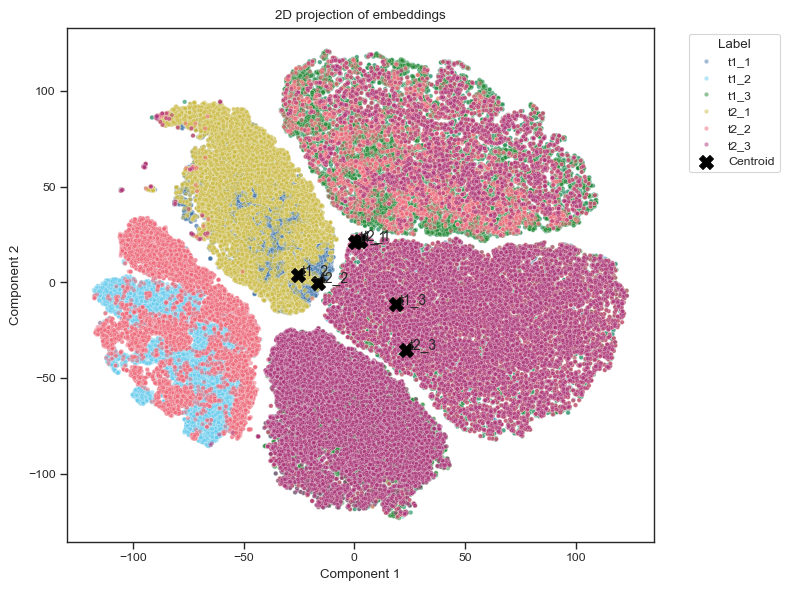

In [7]:

plt.figure(figsize=(8,6))
set_seaborn_style()
sns.scatterplot(x=proj[:,0], y=proj[:,1], hue=labels_cmb, alpha=0.5, s=10)
plt.scatter(
    centroids['x'], centroids['y'],
    c='black', s=100, marker='X', label='Centroid'
)
for _, row in centroids.iterrows():
    plt.text(row['x'] + 1.75, row['y'], str(row['label']), fontsize=10)
plt.title("2D projection of embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
reducer = umap.UMAP()
emb_2d = reducer.fit_transform(embeddings_cmb, ensure_all_finite=False)

/opt/conda/lib/python3.11/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


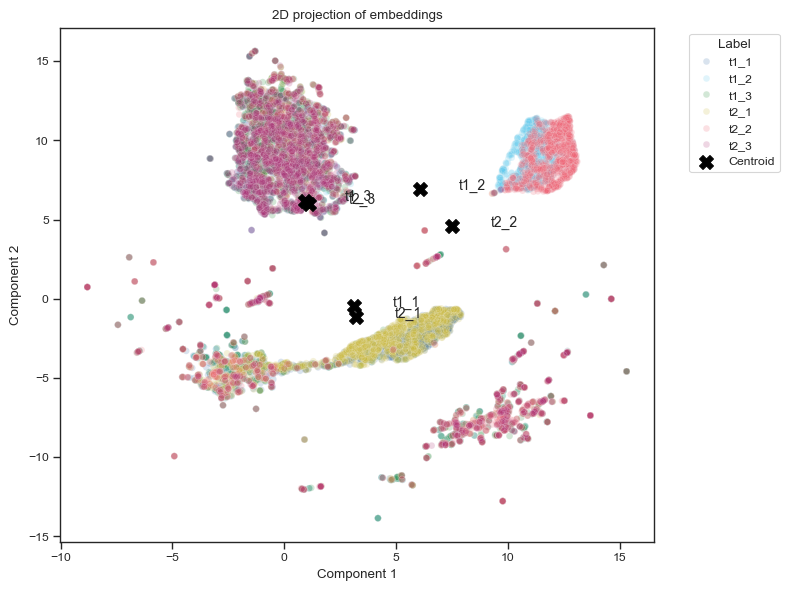

In [ ]:
df = pd.DataFrame({
    'x': emb_2d[:, 0],
    'y': emb_2d[:, 1],
    'label': labels_cmb
})
# Compute centroids
centroids = df.groupby('label')[['x', 'y']].mean().reset_index()

plt.figure(figsize=(8,6))
set_seaborn_style()
sns.scatterplot(x=emb_2d[:,0], y=emb_2d[:,1], hue=labels_cmb, alpha=0.2)
plt.scatter(
    centroids['x'], centroids['y'],
    c='black', s=100, marker='X', label='Centroid'
)
for _, row in centroids.iterrows():
    plt.text(row['x'] + 1.75, row['y'], str(row['label']), fontsize=10)
plt.title("2D projection of embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [10]:
t1_1 = embeddings_cmb[labels_cmb == 't1_1']
t1_2 = embeddings_cmb[labels_cmb == 't1_2']
t1_3 = embeddings_cmb[labels_cmb == 't1_3']
t2_1 = embeddings_cmb[labels_cmb == 't2_1']
t2_2 = embeddings_cmb[labels_cmb == 't2_2']
t2_3 = embeddings_cmb[labels_cmb == 't2_3']

In [11]:
def bootstrap_centroid_distance(emb1, emb2, n_iter=1000):
    dists = []
    for _ in range(n_iter):
        s1 = resample(emb1)
        s2 = resample(emb2)
        centroid1 = np.mean(s1, axis=0)
        centroid2 = np.mean(s2, axis=0)
        dist = np.linalg.norm(centroid1 - centroid2)
        dists.append(dist)
    return np.array(dists)

# Sample
dist_1 = bootstrap_centroid_distance(t1_1, t2_1)
dist_1_baseline = bootstrap_centroid_distance(t1_1, t1_1)
dist_2 = bootstrap_centroid_distance(t1_2, t2_2)
dist_2_baseline = bootstrap_centroid_distance(t1_2, t1_2)
dist_3 = bootstrap_centroid_distance(t1_3, t2_3)
dist_3_baseline = bootstrap_centroid_distance(t1_3, t1_3)

In [14]:
def bootstrap_pairwise_distance(emb1, emb2, n_iter=1000, n_samples=1000):
    dists = []
    for _ in range(n_iter):
        s1 = resample(emb1, n_samples=n_samples)
        s2 = resample(emb2, n_samples=n_samples)
        # Compute pairwise distances between the two sets
        pairwise = np.linalg.norm(s1 - s2, axis=1)  # assumes s1 and s2 are aligned
        dists.append(np.mean(pairwise))  # or np.median(pairwise), etc.
    return np.array(dists)

dist_1 = bootstrap_pairwise_distance(t1_1, t2_1)
dist_1_baseline = bootstrap_pairwise_distance(t1_1, t1_1)
dist_2 = bootstrap_pairwise_distance(t1_2, t2_2)
dist_2_baseline = bootstrap_pairwise_distance(t1_2, t1_2)
dist_3 = bootstrap_pairwise_distance(t1_3, t2_3)
dist_3_baseline = bootstrap_pairwise_distance(t1_3, t1_3)

In [29]:
from sklearn.preprocessing import StandardScaler

# Normalize all embeddings globally (or per task if needed)
scaler = StandardScaler()
scaler.fit(embeddings_cmb)

t1_1_norm = scaler.transform(t1_1)
t2_1_norm = scaler.transform(t2_1)
t1_2_norm = scaler.transform(t1_2)
t2_2_norm = scaler.transform(t2_2)
t1_3_norm = scaler.transform(t1_3)
t2_3_norm = scaler.transform(t2_3)

# Then run your bootstrap analysis on the normalized data
dist_1 = bootstrap_pairwise_distance(t1_1_norm, t2_1_norm)
dist_1_baseline = bootstrap_pairwise_distance(t1_1_norm, t1_1_norm)
dist_2 = bootstrap_pairwise_distance(t1_2_norm, t2_2_norm)
dist_2_baseline = bootstrap_pairwise_distance(t1_2_norm, t1_2_norm)
dist_3 = bootstrap_pairwise_distance(t1_3_norm, t2_3_norm)
dist_3_baseline = bootstrap_pairwise_distance(t1_3_norm, t1_3_norm)

In [26]:
# Compare distributions
# t1_1 == t2_1 is more likely than t1_2 == t2_2
stat, pval = mannwhitneyu(dist_1, dist_2, alternative='less')
print(f"Distance test: stat={stat}, p={pval:.5f}")

# t1_1 == t2_1 is more likely than t1_1 == t1_1
stat, pval = mannwhitneyu(dist_1, dist_1_baseline, alternative='less')
print(f"Distance test: stat={stat}, p={pval:.5f}")

# t1_1 == t2_1 is more likely than t1_3 == t2_3
stat, pval = mannwhitneyu(dist_1, dist_3, alternative='less')
print(f"Distance test: stat={stat}, p={pval:.5f}")

# t1_2 == t2_2 is more likely than t1_2 == t1_2
stat, pval = mannwhitneyu(dist_2, dist_2_baseline, alternative='less')
print(f"Distance test: stat={stat}, p={pval:.5f}")

# t1_3 == t2_3 is more likely than t1_2 == t2_2
stat, pval = mannwhitneyu(dist_3, dist_2, alternative='less')
print(f"Distance test: stat={stat}, p={pval:.5f}")

# t1_3 == t2_3 is more likely than t1_3 == t1_3
stat, pval = mannwhitneyu(dist_3, dist_3_baseline, alternative='less')
print(f"Distance test: stat={stat}, p={pval:.5f}")

Distance test: stat=140467.5, p=0.00000
Distance test: stat=712614.5, p=1.00000
Distance test: stat=1000000.0, p=1.00000
Distance test: stat=1000000.0, p=1.00000
Distance test: stat=0.0, p=0.00000
Distance test: stat=151560.5, p=0.00000


In [31]:
from scipy.stats import ttest_ind

from scipy.stats import ttest_ind

# t1_1 == t2_1 is more likely than t1_2 == t2_2
stat, pval = ttest_ind(dist_1, dist_2, alternative='two-sided')
print(f"T-test (dist_1 != dist_2): stat={stat:.3f}, p={pval:.5f}")

# t1_1 == t2_1 is more likely than t1_1 == t1_1
stat, pval = ttest_ind(dist_1, dist_1_baseline, alternative='two-sided')
print(f"T-test (dist_1 != dist_1_baseline): stat={stat:.3f}, p={pval:.5f}")

# t1_1 == t2_1 is more likely than t1_3 == t2_3
stat, pval = ttest_ind(dist_1, dist_3, alternative='two-sided')
print(f"T-test (dist_1 != dist_3): stat={stat:.3f}, p={pval:.5f}")

# t1_2 == t2_2 is more likely than t1_2 == t1_2
stat, pval = ttest_ind(dist_2, dist_2_baseline, alternative='two-sided')
print(f"T-test (dist_2 != dist_2_baseline): stat={stat:.3f}, p={pval:.5f}")

# t1_3 == t2_3 is more likely than t1_2 == t2_2
stat, pval = ttest_ind(dist_3, dist_2, alternative='two-sided')
print(f"T-test (dist_3 != dist_2): stat={stat:.3f}, p={pval:.5f}")

# t1_3 == t2_3 is more likely than t1_3 == t1_3
stat, pval = ttest_ind(dist_3, dist_3_baseline, alternative='two-sided')
print(f"T-test (dist_3 != dist_3_baseline): stat={stat:.3f}, p={pval:.5f}")


T-test (dist_1 != dist_2): stat=-80.088, p=0.00000
T-test (dist_1 != dist_1_baseline): stat=32.868, p=0.00000
T-test (dist_1 != dist_3): stat=260.039, p=0.00000
T-test (dist_2 != dist_2_baseline): stat=200.931, p=0.00000
T-test (dist_3 != dist_2): stat=-352.954, p=0.00000
T-test (dist_3 != dist_3_baseline): stat=-27.328, p=0.00000


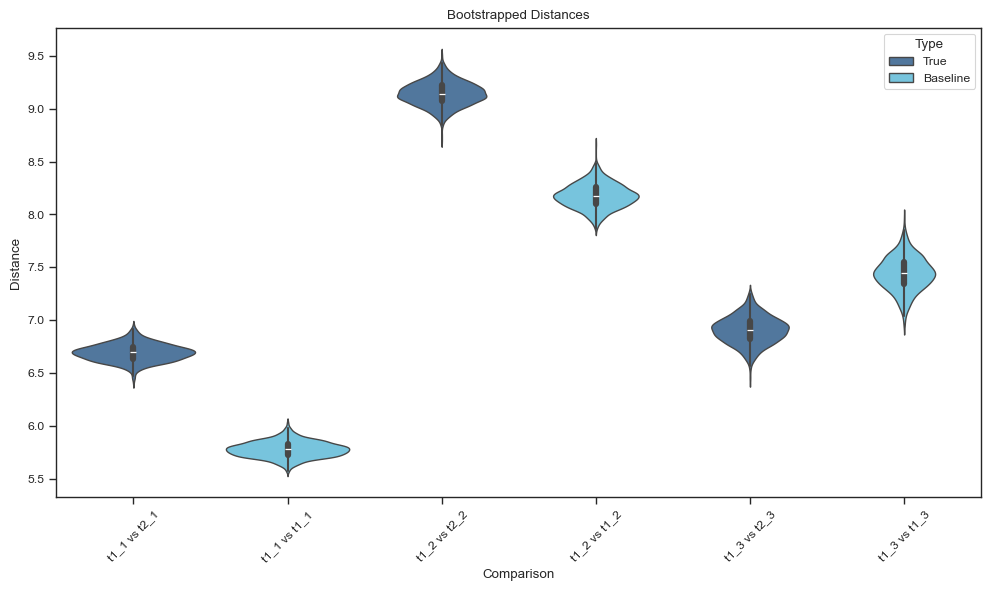

In [15]:
def create_violin_df():
    data = {
        "Distance": np.concatenate([
            dist_1, dist_1_baseline,
            dist_2, dist_2_baseline,
            dist_3, dist_3_baseline
        ]),
        "Comparison": (
            ["t1_1 vs t2_1"] * len(dist_1) +
            ["t1_1 vs t1_1"] * len(dist_1_baseline) +
            ["t1_2 vs t2_2"] * len(dist_2) +
            ["t1_2 vs t1_2"] * len(dist_2_baseline) +
            ["t1_3 vs t2_3"] * len(dist_3) +
            ["t1_3 vs t1_3"] * len(dist_3_baseline)
        ),
        "Type": (
            ["True"] * len(dist_1) +
            ["Baseline"] * len(dist_1_baseline) +
            ["True"] * len(dist_2) +
            ["Baseline"] * len(dist_2_baseline) +
            ["True"] * len(dist_3) +
            ["Baseline"] * len(dist_3_baseline)
        )
    }
    return pd.DataFrame(data)

df = create_violin_df()
set_seaborn_style()
# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=df,
    x="Comparison",
    y="Distance",
    hue="Type",
    split=False,
)
plt.title("Bootstrapped Distances")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
def cohens_d(a, b):
    return (np.mean(a) - np.mean(b)) / np.sqrt((np.std(a, ddof=1)**2 + np.std(b, ddof=1)**2) / 2)

d1 = cohens_d(dist_1, dist_1_baseline)
d2 = cohens_d(dist_2, dist_2_baseline)
d3 = cohens_d(dist_3, dist_3_baseline)

print(f"Cohen's d (t1_1 vs t2_1 vs baseline): {d1:.3f}")
print(f"Cohen's d (t1_2 vs t2_2 vs baseline): {d2:.3f}") # Effect size much larger
print(f"Cohen's d (t1_3 vs t2_3 vs baseline): {d3:.3f}")

Cohen's d (t1_1 vs t2_1 vs baseline): 1.470
Cohen's d (t1_2 vs t2_2 vs baseline): 8.986
Cohen's d (t1_3 vs t2_3 vs baseline): -1.222


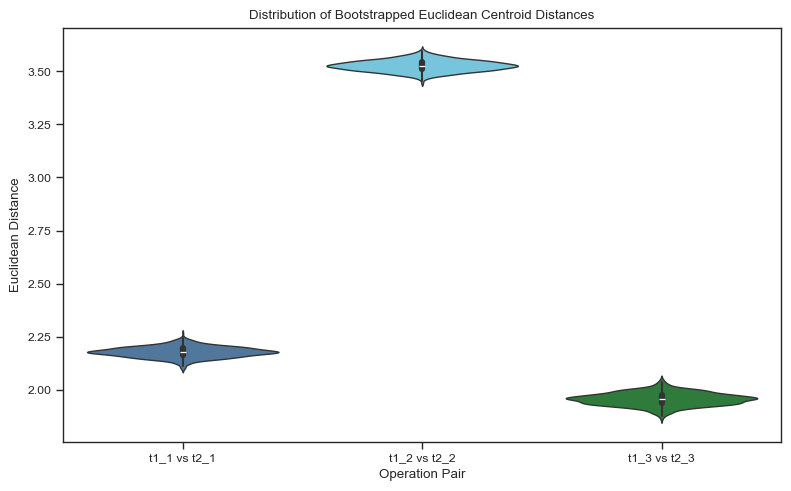

In [12]:
df = pd.DataFrame({
    'Distance': list(dist_1) + list(dist_2) + list(dist_3),
    'Comparison': ['t1_1 vs t2_1'] * len(dist_1) + ['t1_2 vs t2_2'] * len(dist_2) + ['t1_3 vs t2_3'] * len(dist_3)
})

plt.figure(figsize=(8, 5))
sns.violinplot(data=df, x='Comparison', y='Distance', hue='Comparison')
plt.title('Distribution of Bootstrapped Euclidean Centroid Distances')
plt.ylabel('Euclidean Distance')
plt.xlabel('Operation Pair')
plt.tight_layout()
plt.show()
# TODO: Compare to bootstrapped t1_1 vs t1_1 as base?

In [6]:
# 3d visu
tsne = TSNE(n_components=3)
emb_3d = tsne.fit_transform(embeddings_cmb)  # shape (N, 3)

In [9]:
import plotly.express as px
import pandas as pd

# Create a DataFrame
df = pd.DataFrame(emb_3d, columns=['x', 'y', 'z'])
df['label'] = labels_cmb  # replace with your actual label list

# Interactive 3D scatter plot
fig = px.scatter_3d(df, x='x', y='y', z='z',
                    color='label',
                    opacity=1,
                    title="3D Embedding Projection",
                    labels={'label': 'Class'},
                    hover_name='label')

fig.update_traces(marker=dict(size=4))
fig.show()

### Combined

In [84]:
t1_embs_ds = xr.load_dataset("files/prp_t1_embeddings.nc")
t2_embs_ds = xr.load_dataset("files/prp_t2_embeddings.nc")

labels_t1 = []
embeddings_t1 = []
for label in t1_embs_ds.labels.values:
    label_subset = t1_embs_ds.sel(labels=label)
    embeddings_subset = label_subset.embeddings.values.reshape(-1, label_subset.emb_dim.size)
    embeddings_subset = embeddings_subset[~np.isnan(embeddings_subset).any(axis=1)]
    print(f"Label: {label}, Shape: {embeddings_subset.shape}")
    labels_t1.extend([label] * embeddings_subset.shape[0])
    embeddings_t1.append(embeddings_subset)
labels_t1 = np.array(labels_t1)
embeddings_t1 = np.concatenate(embeddings_t1, axis=0)

labels_t2 = []
embeddings_t2 = []
for label in t2_embs_ds.labels.values:
    label_subset = t2_embs_ds.sel(labels=label)
    embeddings_subset = label_subset.embeddings.values.reshape(-1, label_subset.emb_dim.size)
    embeddings_subset = embeddings_subset[~np.isnan(embeddings_subset).any(axis=1)]
    print(f"Label: {label}, Shape: {embeddings_subset.shape}")
    labels_t2.extend([label] * embeddings_subset.shape[0])
    embeddings_t2.append(embeddings_subset)
labels_t2 = np.array(labels_t2)
embeddings_t2 = np.concatenate(embeddings_t2, axis=0)

Label: prp_t1_1, Shape: (2210, 513)
Label: prp_t1_2, Shape: (2210, 513)
Label: prp_t1_3, Shape: (2210, 513)
Label: prp_t2_1, Shape: (2158, 513)
Label: prp_t2_2, Shape: (2158, 513)
Label: prp_t2_3, Shape: (2158, 513)


In [93]:
from scipy.linalg import orthogonal_procrustes
t1_response = embeddings_t1[labels_t1 == "prp_t1_1"]
t2_response = embeddings_t2[labels_t2 == "prp_t2_3"]

t1_mean = t1_response.mean(axis=0)
t2_mean = t2_response.mean(axis=0)

t1_response_centered = t1_response - t1_mean
t2_response_centered = t2_response - t2_mean

R, _ = orthogonal_procrustes(t1_response_centered[:2158], t2_response_centered)

t1_all_centered = embeddings_t1 - t1_mean
t1_aligned = t1_all_centered @ R + t2_mean

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cos_sim = cosine_similarity(t1_response, t2_response)
print(cos_sim.mean())

In [4]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(np.concatenate([embeddings_t1, embeddings_t2], axis=0))

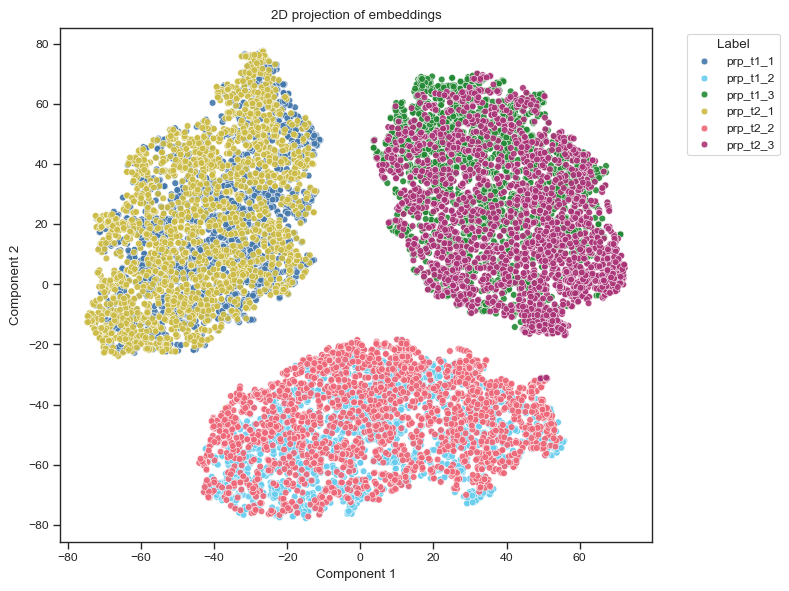

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,6))
set_seaborn_style()
sns.scatterplot(x=proj[:,0], y=proj[:,1], hue=np.concatenate([labels_t1, labels_t2], axis=0), alpha=0.9)
plt.title("2D projection of embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
import umap
reducer = umap.UMAP()
emb_2d = reducer.fit_transform(np.concatenate([t1_aligned, embeddings_t2], axis=0), ensure_all_finite=False)

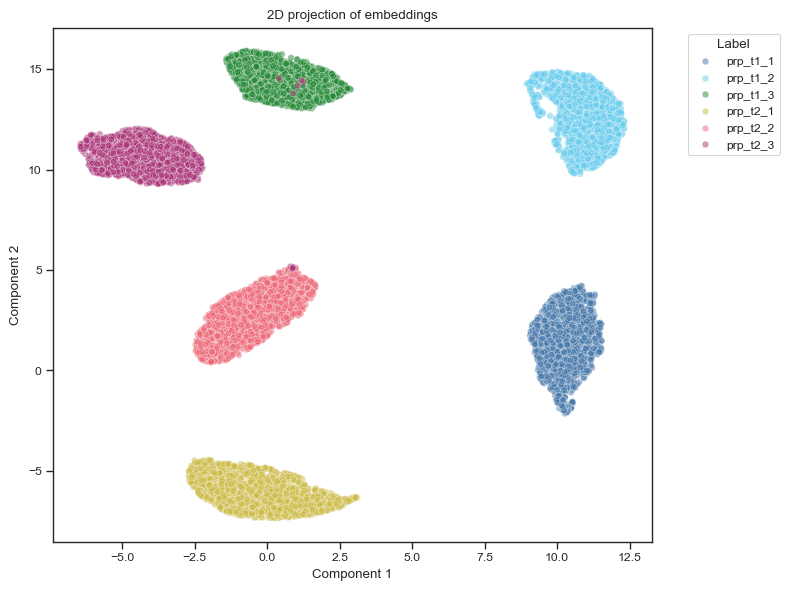

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,6))
set_seaborn_style()
sns.scatterplot(x=emb_2d[:,0], y=emb_2d[:,1], hue=np.concatenate([labels_t1, labels_t2], axis=0), alpha=0.5)
plt.title("2D projection of embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### prp/task1

In [2]:
t1_embs_ds = xr.load_dataset("files/prp_t1_embeddings.nc")

In [7]:
labels_t1 = []
embeddings_t1 = []
for label in t1_embs_ds.labels.values:
    label_subset = t1_embs_ds.sel(labels=label)
    embeddings_subset = label_subset.embeddings.values.reshape(-1, label_subset.emb_dim.size)
    embeddings_subset = embeddings_subset[~np.isnan(embeddings_subset).any(axis=1)]
    print(f"Label: {label}, Shape: {embeddings_subset.shape}")
    labels_t1.extend([label] * embeddings_subset.shape[0])
    embeddings_t1.append(embeddings_subset)
embeddings_t1 = np.concatenate(embeddings_t1, axis=0)

Label: prp_t1_1, Shape: (2210, 513)
Label: prp_t1_2, Shape: (2210, 513)
Label: prp_t1_3, Shape: (2210, 513)


In [8]:
import umap
reducer = umap.UMAP()
emb_2d = reducer.fit_transform(embeddings_t1, ensure_all_finite=False)

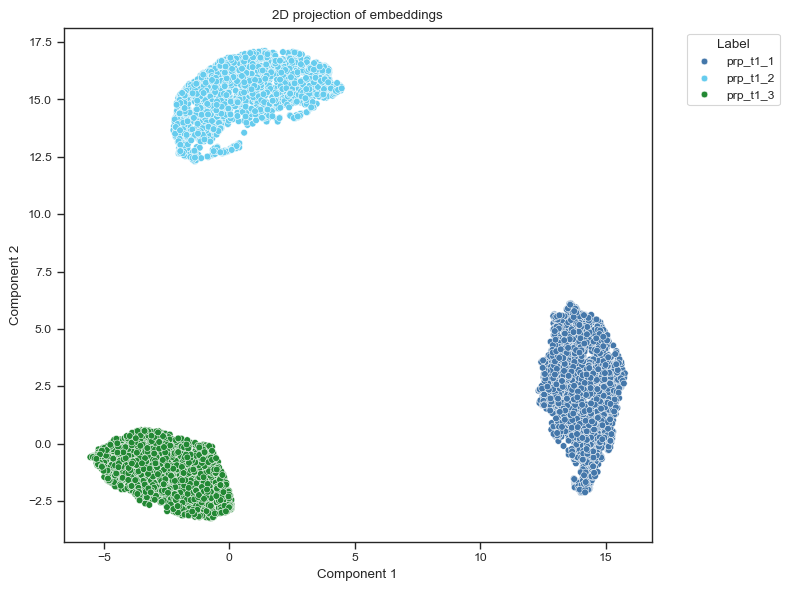

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,6))
set_seaborn_style()
sns.scatterplot(x=emb_2d[:,0], y=emb_2d[:,1], hue=labels_t1)
plt.title("2D projection of embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### prp/task2

In [10]:
t2_embs_ds = xr.load_dataset("files/prp_t2_embeddings.nc")

In [11]:
labels_t2 = []
embeddings_t2 = []
for label in t2_embs_ds.labels.values:
    label_subset = t2_embs_ds.sel(labels=label)
    embeddings_subset = label_subset.embeddings.values.reshape(-1, label_subset.emb_dim.size)
    embeddings_subset = embeddings_subset[~np.isnan(embeddings_subset).any(axis=1)]
    print(f"Label: {label}, Shape: {embeddings_subset.shape}")
    labels_t2.extend([label] * embeddings_subset.shape[0])
    embeddings_t2.append(embeddings_subset)
embeddings_t2 = np.concatenate(embeddings_t2, axis=0)

Label: prp_t2_1, Shape: (2158, 513)
Label: prp_t2_2, Shape: (2158, 513)
Label: prp_t2_3, Shape: (2158, 513)


In [12]:
import umap
reducer = umap.UMAP()
emb_2d = reducer.fit_transform(embeddings_t2, ensure_all_finite=False)

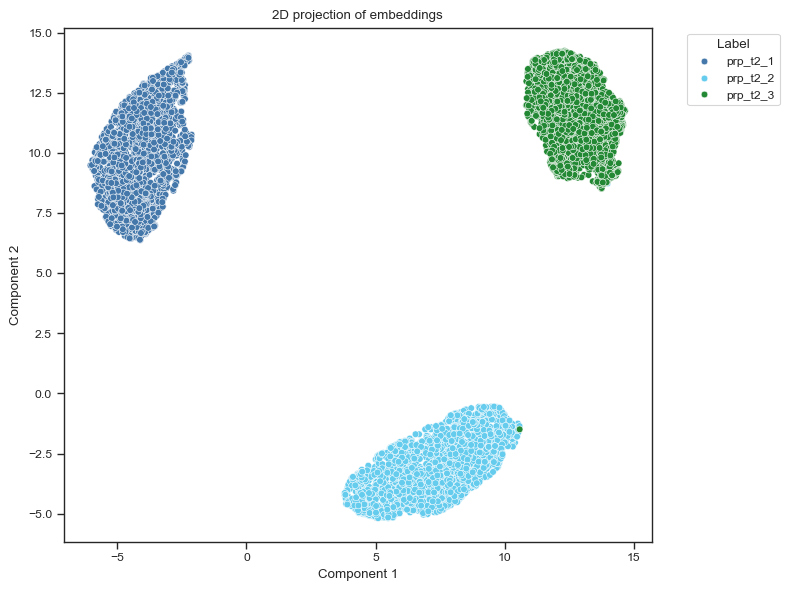

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,6))
set_seaborn_style()
sns.scatterplot(x=emb_2d[:,0], y=emb_2d[:,1], hue=labels_t2)
plt.title("2D projection of embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()